In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras as k
import tensorflow_addons as tfa
import tensorflow.keras.layers as kl
from tensorflow.keras import optimizers 
from tensorflow.keras import regularizers 
from tensorflow.keras import losses 
from tensorflow.keras import metrics as kmetrics
from sklearn import metrics as skmetrics
import matplotlib.pyplot as plt

from IPython.display import clear_output

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

from IPython import display
from datetime import datetime as dt

from data.utils import WindowDataset

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)
plt.rcParams["figure.figsize"] = (16, 8)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
   # Currently, memory growth needs to be the same across GPUs
   try:
       for gpu in gpus:
           tf.config.experimental.set_memory_growth(gpu, True)
   except RuntimeError as e:
       print(e)

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), markerscale=4, fontsize=18)        

from matplotlib import cm
import matplotlib

color_nominal = matplotlib.colors.to_rgba('C2')
color_pga_leak = matplotlib.colors.to_rgba('C1')
color_fluid_leak = matplotlib.colors.to_rgba('C0')
color_cooler_fault = matplotlib.colors.to_rgba('C4')
color_valve_error = matplotlib.colors.to_rgba('C3')


    
%matplotlib inline

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Parameters

In [3]:
data_path = os.environ['ENGINE_FAULT_DETECTION_PROJECT_DATA_PATH']
models_path = os.environ['ENGINE_FAULT_DETECTION_PROJECT_MODELS_PATH']

class Bunch:
    __init__ = lambda self, **kw: setattr(self, '__dict__', kw)
args = Bunch()    

args.window_size = 5000
args.train_test_split_ratio = 0.9
args.portion = 1.0
args.batch_size = 2**7
args.epochs = 10000
args.windows_per_epoch = int(1e6)
args.active_channels = 17
args.initial_learning_rate = 3e-3
args.decay = args.initial_learning_rate / args.epochs
args.warmup_steps = 1

model_name = 'GCAEC_zema_multilabel_50sec'
dataset_path = '../../data/condition_monitoring_of_hydraulic_systems_data_set_at_ZeMA/condition_monitoring_of_hydraulic_systems_data_set_at_ZeMA_multilabel.csv'

now = dt.now()
log_name = '{}_epochs_{}_{}_{}_{}.h5'.format(model_name, args.epochs, now.day, now.hour, now.minute)
hist_log_name = '{}_epochs_{}_{}_{}_{}.csv'.format(model_name, args.epochs, now.day, now.hour, now.minute)

In [4]:
def noam_based_decay(epoch, lr):
    epoch += 1    
    return args.initial_learning_rate * args.warmup_steps**0.5 * min(epoch**-0.5, epoch*(args.warmup_steps**-1.5)) 

# Dataset

In [5]:
dataset_description = pd.read_csv(dataset_path, skipinitialspace=True)
dataset_description

fp  cid                      name
0     sensors_numpy/record_0000.npy    2  Неисправность охлаждения
1     sensors_numpy/record_0001.npy    2  Неисправность охлаждения
2     sensors_numpy/record_0002.npy    2  Неисправность охлаждения
3     sensors_numpy/record_0003.npy    2  Неисправность охлаждения
4     sensors_numpy/record_0004.npy    2  Неисправность охлаждения
...                             ...  ...                       ...
2200  sensors_numpy/record_2200.npy   16  Утечка газа аккумулятора
2201  sensors_numpy/record_2201.npy   16  Утечка газа аккумулятора
2202  sensors_numpy/record_2202.npy   16  Утечка газа аккумулятора
2203  sensors_numpy/record_2203.npy   16  Утечка газа аккумулятора
2204  sensors_numpy/record_2204.npy   16  Утечка газа аккумулятора

[2205 rows x 3 columns]

In [6]:
X = WindowDataset(dataset_path, window_size=args.window_size, initial_shuffle=True, portion=args.portion, active_channels=args.active_channels, verbose=False)

In [7]:
class_names = list(X.class_names.values())
class_names

['Неисправность охлаждения',
 'Неисправность охлаждения,Утечка жидкости в насосе',
 'Неисправность охлаждения,Задержка срабатывания клапана,Утечка жидкости в насосе',
 'Неисправность охлаждения,Задержка срабатывания клапана',
 'Неисправность охлаждения,Утечка газа аккумулятора',
 'Неисправность охлаждения,Утечка жидкости в насосе,Утечка газа аккумулятора',
 'Неисправность охлаждения,Задержка срабатывания клапана,Утечка жидкости в насосе,Утечка газа аккумулятора',
 'Неисправность охлаждения,Задержка срабатывания клапана,Утечка газа аккумулятора',
 'Утечка газа аккумулятора',
 'Исправная',
 'Утечка жидкости в насосе',
 'Задержка срабатывания клапана,Утечка жидкости в насосе',
 'Задержка срабатывания клапана',
 'Утечка жидкости в насосе,Утечка газа аккумулятора',
 'Задержка срабатывания клапана,Утечка жидкости в насосе,Утечка газа аккумулятора',
 'Задержка срабатывания клапана,Утечка газа аккумулятора']

In [8]:
number_of_classes = 5
one_hot = {i:[(i & 2**p != 0) for p in range(number_of_classes)] for i in range(2**number_of_classes)}

In [9]:
unique_class_colors = np.array([color_nominal, color_cooler_fault, color_valve_error, color_fluid_leak, color_pga_leak])  

def code_to_color(code):
    return np.array([unique_class_color for i, unique_class_color in enumerate(unique_class_colors) if code[i]])

class_colors = {label:np.mean(code_to_color(code), axis=0) for label, code in one_hot.items() if label!=0}

In [10]:
X_train = X.get_generator(
    get_item=lambda cid, w: (w.T, (w.T, one_hot[cid], cid)),
    get_types=lambda: (tf.float32, (tf.float32, tf.bool, tf.int8)),
    get_shape=lambda: (tf.TensorShape([args.window_size, args.active_channels]),  (tf.TensorShape([args.window_size, args.active_channels]), tf.TensorShape([number_of_classes]), tf.TensorShape([]))),
    train=True, 
    shuffle_windows=True,
    kidx=0,
    train_test_split_ratio=args.train_test_split_ratio)

X_test = X.get_generator(
    get_item=lambda cid, w: (w.T, (w.T, one_hot[cid], cid)),
    get_types=lambda: (tf.float32, (tf.float32, tf.bool, tf.int8)),
    get_shape=lambda: (tf.TensorShape([args.window_size, args.active_channels]),  (tf.TensorShape([args.window_size, args.active_channels]), tf.TensorShape([number_of_classes]), tf.TensorShape([]))),
    train=False, 
    shuffle_windows=True,
    kidx=0,
    train_test_split_ratio=args.train_test_split_ratio)

In [11]:
X_test_classifier, test_labels_true = X.get_generator(
    get_item=lambda cid, w: (w.T, (one_hot[cid], cid)),
    get_types=lambda: (tf.float32, (tf.bool, tf.int8)),
    get_shape=lambda: (tf.TensorShape([args.window_size, args.active_channels]),  ( tf.TensorShape([number_of_classes]), tf.TensorShape([]))),
    train=False, 
    shuffle_windows=True,
    kidx=0,
    train_test_split_ratio=args.train_test_split_ratio,
    return_true_labels=True)

# Model

In [12]:
input_shape = (X.window_size, X.active_channels)
embedding_size = 2
units = 32
kernel_size = 3

conv_num = -1
def conv_block_name():
    global conv_num
    conv_num = conv_num + 1
    return 'cb_{}'.format(conv_num)

def conv_block(output_timesteps, output_channels, name):
    def f(preceding_layer):
        input_timesteps, input_channels = preceding_layer.get_shape().as_list()[1:]
        
        inputs = k.Input(shape=(input_timesteps, input_channels))
               
        act = kl.Conv1D(output_channels, kernel_size=kernel_size, activation='linear', padding='same', name=name+'_conv_features1')(inputs)
        gate = kl.Conv1D(output_channels, kernel_size=kernel_size, activation='sigmoid', padding='same', name=name+'_conv_memory')(inputs)
        gated_act = kl.Multiply()([tfa.layers.InstanceNormalization()(kl.PReLU()(act)), gate]) 
               
        a = kl.Permute((2,1))(gated_act)
        b = kl.Dense(output_timesteps)(a)
        c = kl.Permute((2,1))(b)
        
        m = k.Model(inputs=inputs, outputs=[c, gate], name=name)
#         m.summary()
        return m(preceding_layer)
    return f

inputs = k.Input(shape=input_shape)

e, g0 = conv_block(output_timesteps=1000, output_channels=units, name=conv_block_name())(inputs)
e, g1 = conv_block(output_timesteps=100, output_channels=units, name=conv_block_name())(inputs)
e, g2 = conv_block(output_timesteps=50, output_channels=units, name=conv_block_name())(e)
e, g3 = conv_block(output_timesteps=25, output_channels=units, name=conv_block_name())(e)
e, g4 = conv_block(output_timesteps=10, output_channels=units, name=conv_block_name())(e)

d, g5 = conv_block(output_timesteps=25, output_channels=units, name=conv_block_name())(e)
d, g6 = conv_block(output_timesteps=50, output_channels=units, name=conv_block_name())(d)
d, g7 = conv_block(output_timesteps=100, output_channels=units, name=conv_block_name())(d)
d, g9 = conv_block(output_timesteps=1000, output_channels=units, name=conv_block_name())(d)
d, g8 = conv_block(output_timesteps=X.window_size, output_channels=X.active_channels, name='decoder_output')(d)

decoder_output = d

ef = kl.Flatten()(e)
embedding_output = kl.Dense(embedding_size, activation='linear', name='emb')(ef)
is_nominal, is_fault = tf.split(kl.Dense(2, activation='softmax', name='softmax_layer')(embedding_output), 2, axis=-1)
sigmoid_output = kl.Concatenate(name='sigmoid_layer')([is_nominal, kl.Dense(4, activation='sigmoid')(embedding_output)*is_fault])

powers_of_two = np.array([2**p for p in range(number_of_classes)])[:,np.newaxis]

label_output = kl.Lambda(lambda x: (tf.cast((x>0.5), float)@powers_of_two), name='label_layer')(sigmoid_output)

autoencoder_model = k.Model(inputs=inputs, outputs=[decoder_output, sigmoid_output, label_output], name='autoencoder')
encoder_model = k.Model(inputs=inputs, outputs=embedding_output, name='encoder')
classifier_model = k.Model(inputs=inputs, outputs=[sigmoid_output, label_output], name='classifier')

autoencoder_model.summary()

Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5000, 17)]   0                                            
__________________________________________________________________________________________________
cb_1 (Functional)               [(None, 100, 32), (N 663492      input_1[0][0]                    
__________________________________________________________________________________________________
cb_2 (Functional)               [(None, 50, 32), (No 14522       cb_1[0][0]                       
__________________________________________________________________________________________________
cb_3 (Functional)               [(None, 25, 32), (No 9147        cb_2[0][0]                       
________________________________________________________________________________________

# Train

In [13]:
class History:
    def __init__(self, path):
        self.path = path
        self.train_loss = []
        self.train_ae_loss = []
        self.train_classifier_loss = []
        self.train_classifier_acc = []
        
        self.test_loss = []
        self.test_ae_loss = []
        self.test_classifier_loss = []
        self.test_classifier_acc = []

        
    def save_state(self):
        df = pd.DataFrame({i:d[i] for i in self.__dict__ if i != 'path'})
        df.to_csv(self.path, index=False)
    
    def load_state(self):
        df = pd.read_csv(self.path)
        for c in df.columns:
            self.__dict__[c] = df[c].to_list()
        
history = History(hist_log_name)

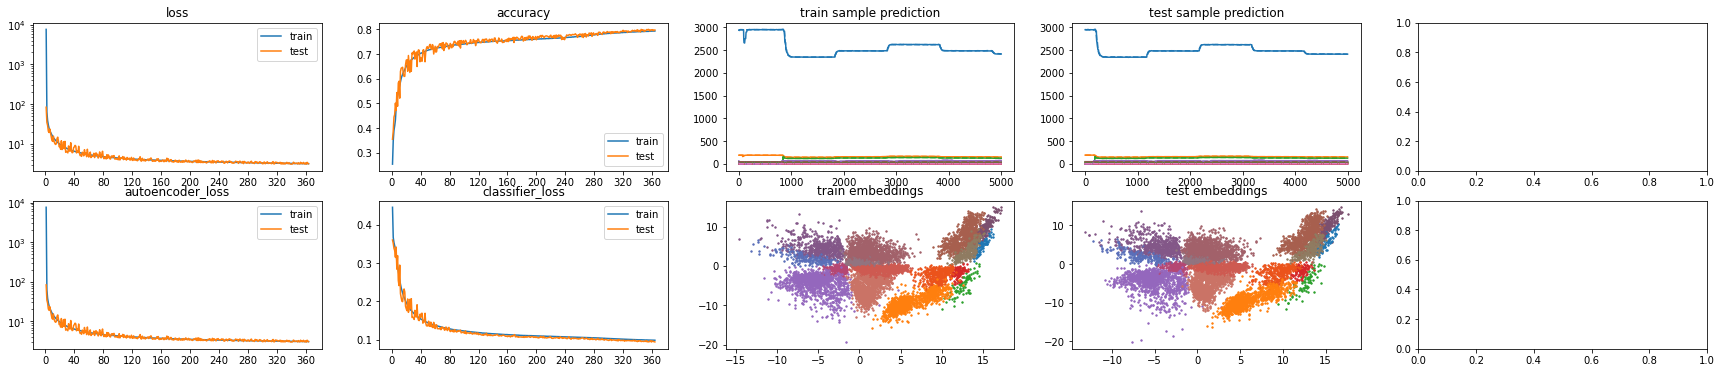

4 days, 2:40:17.001080 364/10000
train_loss: 3.1854622, test_loss:3.1609471
train_acc: 79.32, test_acc:79.72
train_ae_loss: 3.0871472, test_ae_loss:3.0670769
Epoch 365/10000

Epoch 00365: LearningRateScheduler reducing learning rate to 0.0001570271767770641.
2803/7813 [=========>....................] - ETA: 9:25 - loss: 3.1705 - decoder_output_loss: 3.0731 - sigmoid_layer_loss: 0.0974 - label_layer_accuracy: 0.7951

In [ ]:
%%time 

start_time = dt.now()

fig, [[ax1, ax2, ax3, ax4, ax5], [ax10, ax20, ax30, ax40, ax50]] = plt.subplots(2,5, figsize=(30,6), gridspec_kw={'width_ratios':[0.2, 0.2, 0.2, 0.2, 0.2]})

# samples = max(10000, int(X.number_of_windows*0.1))
samples = 10000

callbacks = []
class DrawingCallback(k.callbacks.Callback):
    def __init__(self, history):
        self.history = history
        self.train_sample = X_train.take(samples)
        self.test_sample = X_test.take(samples)
        self.train_sample_1 = list(X_train.take(1).as_numpy_iterator())[0][0]
        self.test_sample_1 = list(X_test.take(1).as_numpy_iterator())[0][0]
    
    def on_epoch_end(self, epoch, logs={}):
        train_results = logs
        train_loss, train_ae_loss, train_classifier_loss, train_classifier_acc = train_results['loss'], train_results['decoder_output_loss'], train_results['sigmoid_layer_loss'], train_results['label_layer_accuracy']
        
        test_results = autoencoder_model.evaluate(self.test_sample.batch(args.batch_size), return_dict=True)
        test_loss, test_ae_loss, test_classifier_loss, test_classifier_acc = test_results['loss'], test_results['decoder_output_loss'], test_results['sigmoid_layer_loss'], test_results['label_layer_accuracy']
        
        predicted_train, _, _ = autoencoder_model.predict(self.train_sample_1[np.newaxis])
        predicted_test, _, _ = autoencoder_model.predict(self.test_sample_1[np.newaxis])
        predicted_train_z = encoder_model.predict(self.train_sample.batch(args.batch_size))
        predicted_test_z = encoder_model.predict(self.test_sample.batch(args.batch_size))
        
        self.history.train_loss.append(train_loss)
        self.history.train_ae_loss.append(train_ae_loss)
        self.history.train_classifier_loss.append(train_classifier_loss)
        self.history.train_classifier_acc.append(train_classifier_acc)
        self.history.test_loss.append(test_loss)
        self.history.test_ae_loss.append(test_ae_loss)
        self.history.test_classifier_loss.append(test_classifier_loss)
        self.history.test_classifier_acc.append(test_classifier_acc)
               
        ax1.cla()
        ax2.cla()
        ax3.cla()
        ax4.cla()
        ax5.cla()
        ax10.cla()
        ax20.cla()
        ax30.cla()
        ax40.cla()
        ax50.cla()
        
        ax1.set_title("loss")
        ax10.set_title("autoencoder_loss")
        ax20.set_title("classifier_loss")
        ax2.set_title("accuracy")
        
        ax1.set_yscale('log')
        ax10.set_yscale('log')
        
        ax3.set_title("train sample prediction")
        ax4.set_title("test sample prediction")
        ax30.set_title("train embeddings")
        ax40.set_title("test embeddings")

        ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax1.plot(range(1, len(self.history.train_loss)+1), self.history.train_loss, label='train')
        ax1.plot(range(1, len(self.history.test_loss)+1), self.history.test_loss, label='test')
        ax1.legend()        
    
        ax2.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax2.plot(range(1, len(self.history.train_classifier_acc)+1), self.history.train_classifier_acc, label='train')
        ax2.plot(range(1, len(self.history.test_classifier_acc)+1), self.history.test_classifier_acc, label='test')
        ax2.legend()
        
        ax10.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax10.plot(range(1, len(self.history.train_ae_loss)+1), self.history.train_ae_loss, label='train')
        ax10.plot(range(1, len(self.history.test_ae_loss)+1), self.history.test_ae_loss, label='test')
        ax10.legend()
        
        ax20.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax20.plot(range(1, len(self.history.train_classifier_loss)+1), self.history.train_classifier_loss, label='train')
        ax20.plot(range(1, len(self.history.test_classifier_loss)+1), self.history.test_classifier_loss, label='test')
        ax20.legend()
        
        Xtrain_sample = self.train_sample_1 
        ax3.plot(Xtrain_sample, label='true')
        ax3.set_prop_cycle(None)
        ax3.plot(predicted_train[0], label='predicted', linestyle='dashed')
#         ax3.legend()
        
        Xtest_sample = self.test_sample_1
        ax4.plot(Xtest_sample, label='true')
        ax4.set_prop_cycle(None)
        ax4.plot(predicted_test[0], label='predicted', linestyle='dashed')
#         ax4.legend()
        

#         def legend_without_duplicate_labels(ax):
#             handles, labels = ax.get_legend_handles_labels()
#             unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
#             ax.legend(*zip(*unique))

        for i in range(X.number_of_source_files):
            x = predicted_train_z[np.arange(samples)%X.number_of_source_files==i,0]
            y = predicted_train_z[np.arange(samples)%X.number_of_source_files==i,1]
            class_label = X.timeseries_class_labels[i]
            class_name = X.class_names[class_label]
            class_color = class_colors[class_label]
            ax30.scatter(x, y, s=2, label=class_name, color=class_color)       
            
#         ax30.legend()
        
#         legend_without_duplicate_labels(ax30)
        
        for i in range(X.number_of_source_files):
            x = predicted_test_z[np.arange(samples)%X.number_of_source_files==i,0]
            y = predicted_test_z[np.arange(samples)%X.number_of_source_files==i,1]
            class_label = X.timeseries_class_labels[i]
            class_name = X.class_names[class_label]
            class_color = class_colors[class_label]
            ax40.scatter(x, y, s=2, label=class_name, color=class_color)       

#         ax40.legend()
#         legend_without_duplicate_labels(ax40)

        display.clear_output(wait=True)
        display.display(fig)
        print("{} {}/{}".format(dt.now()-start_time, epoch+1, args.epochs))
        print("train_loss: {:.7f}, test_loss:{:.7f}".format(self.history.train_loss[-1], self.history.test_loss[-1]))
        print("train_acc: {:.2f}, test_acc:{:.2f}".format(self.history.train_classifier_acc[-1]*100, self.history.test_classifier_acc[-1]*100))
        print("train_ae_loss: {:.7f}, test_ae_loss:{:.7f}".format(self.history.train_ae_loss[-1], self.history.test_ae_loss[-1]))


callbacks.append(DrawingCallback(history))

tensorboard_logs_dir = os.environ['ENGINE_FAULT_DETECTION_PROJECT_LOGS_PATH'] + 'tensorboard/'

log_dir = tensorboard_logs_dir + log_name
callbacks.append(k.callbacks.TensorBoard(log_dir=log_dir + '', histogram_freq=1))

callbacks.append(k.callbacks.LearningRateScheduler(noam_based_decay, verbose=1))
opt = optimizers.Adam(learning_rate=args.initial_learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

autoencoder_model.compile(optimizer=opt, 
                          loss={'decoder_output':losses.MSE,
                                'sigmoid_layer':losses.BinaryCrossentropy()}, 
                          loss_weights={'decoder_output':1.0, 'sigmoid_layer':1.0, 'label_layer':0.0},
                          metrics={
                             'label_layer': kmetrics.Accuracy(),
                          }
                         )

autoencoder_model.fit(X_train.take(args.windows_per_epoch).batch(args.batch_size), epochs=args.epochs,  verbose=1, callbacks=callbacks)

In [ ]:
autoencoder_model.save(models_path + model_name + '_ae.h5')
encoder_model.save(models_path + model_name + '_e.h5')
classifier_model.save(models_path + model_name + '_c.h5')

# Test

In [21]:
%%time

test_probs_predicted, test_labels_predicted = classifier_model.predict(X_test_classifier.batch(args.batch_size))

CPU times: user 1min 8s, sys: 17.9 s, total: 1min 26s
Wall time: 1min 31s


In [22]:
test_accuracy = skmetrics.accuracy_score(test_labels_true, test_labels_predicted)
test_balanced_accuracy = skmetrics.balanced_accuracy_score(test_labels_true, test_labels_predicted)
test_precision = skmetrics.precision_score(test_labels_true, test_labels_predicted, average='macro')
test_recall = skmetrics.recall_score(test_labels_true, test_labels_predicted, average='macro')
test_f1 = skmetrics.f1_score(test_labels_true, test_labels_predicted, average='macro')
test_mcc = skmetrics.matthews_corrcoef(test_labels_true, test_labels_predicted)

/home/vlpr/miniconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/vlpr/miniconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vlpr/miniconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
metrics = pd.DataFrame([[test_accuracy*100, test_balanced_accuracy*100, test_precision, test_recall, test_f1, test_mcc]], 
                       columns=['accuracy', 'balanced_accuracy', 'precision (macro avg)', 'recall (macro avg)', 'f1 (macro avg)', 'MCC'],
                       index=['test'])
metrics

accuracy  balanced_accuracy  precision (macro avg)  recall (macro avg)  f1 (macro avg)     MCC
test  79.463416          57.938442               0.517774            0.545303        0.496141  0.7748

In [24]:
def custom_classification_report(true, predicted):
    class_labels = sorted(set(true))
    report_rows = []
    for cid in class_labels:
        class_true = true.copy()
        class_true[true!=cid] = 0
        class_true[true==cid] = 1
        class_predicted = predicted.copy()
        class_predicted[predicted!=cid] = 0
        class_predicted[predicted==cid] = 1
        
        accuracy = skmetrics.accuracy_score(class_true, class_predicted)
        balanced_accuracy = skmetrics.balanced_accuracy_score(class_true, class_predicted)
        precision = skmetrics.precision_score(class_true, class_predicted, average='binary')
        recall = skmetrics.recall_score(class_true, class_predicted, average='binary')
        f1 = skmetrics.f1_score(class_true, class_predicted, average='binary')
        mcc = skmetrics.matthews_corrcoef(class_true, class_predicted)
        report_rows.append([accuracy*100, balanced_accuracy*100, precision, recall, f1, mcc])
    
    accuracy = skmetrics.accuracy_score(true, predicted)
    balanced_accuracy = skmetrics.balanced_accuracy_score(true, predicted)
    precision = skmetrics.precision_score(true, predicted, average='macro')
    recall = skmetrics.recall_score(true, predicted, average='macro')
    f1 = skmetrics.f1_score(true, predicted, average='macro')
    mcc = skmetrics.matthews_corrcoef(true, predicted)
    report_rows.append([accuracy*100, balanced_accuracy*100, precision, recall, f1, mcc])
    
    report = pd.DataFrame(
        report_rows, 
        columns=['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1', 'MCC'],
        index=class_names + ['Total'] )
    
    return report


In [34]:
len(set(test_labels_predicted.flatten()))

12

In [26]:
print(classification_report(test_labels_true, np.squeeze(test_labels_predicted), target_names=X.class_names.values()))

ValueError: Number of classes, 17, does not match size of target_names, 16. Try specifying the labels parameter

In [ ]:
cf = confusion_matrix(test_labels_true, test_labels_predicted, normalize=None)

df_cm = pd.DataFrame(cf, index = X.class_names.values(), columns = X.class_names.values())

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.ylabel('True')
plt.gca().set_yticklabels(plt.gca().get_yticklabels(), rotation=0)
plt.xlabel('Predicted')
plt.title("Симуляционные данные\n\n" + classification_report(test_labels_true, test_labels_predicted, target_names=X.class_names.values()), loc="right")

In [37]:
embeddings = encoder_model.predict(X_test_classifier.batch(args.batch_size))

In [ ]:
scale = 1
f, ax = plt.subplots(1,1, figsize=(8*scale, 8*scale))

for class_label, class_name, class_color in zip(X.class_names.keys(), X.class_names.values(), class_colors):
    x = embeddings[test_labels_true==class_label, 0]
    y = embeddings[test_labels_true==class_label, 1]    
    ax.scatter(x, y, s=1, label=class_name, color=class_color, alpha=1)       
    
ax.legend(loc='lower left', markerscale=8, fontsize=18);

In [35]:
metrics = custom_classification_report(test_labels_true, test_labels_predicted)
metrics

/home/vlpr/miniconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vlpr/miniconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/vlpr/miniconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vlpr/miniconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp /

accuracy  balanced_accuracy  precision    recall        f1       MCC
Неисправность охлаждения                                                                              99.277969          93.705346   0.579634  0.880245  0.698989  0.711091
Неисправность охлаждения,Утечка жидкости в насосе                                                     97.324263          98.371655   0.805393  0.997136  0.891066  0.882503
Неисправность охлаждения,Задержка срабатывания клапана,Утечка жидкости в насосе                       98.639456          50.000000   0.000000  0.000000  0.000000  0.000000
Неисправность охлаждения,Задержка срабатывания клапана                                                97.278912          50.000000   0.000000  0.000000  0.000000  0.000000
Неисправность охлаждения,Утечка газа аккумулятора                                                     99.002268          50.000000   0.000000  0.000000  0.000000  0.000000
Неисправность охлаждения,Утечка жидкости в насосе,Утечка газа аккумулятора                            99.235311          91.111877   0.797611  0.826508  0.811802  0.808034
Неисправность охлаждения,Задержка срабатывания клапана,Утечка жидкости в насосе,Утечка газа аккум...  97.278912          50.000000   0.000000  0.000000  0.000000  0.000000
Неисправность охлаждения,Задержка срабатывания клапана,Утечка газа аккумулятора                       99.240251          97.106068   0.916121  0.947112  0.931359  0.927483
Утечка газа аккумулятора                                                                              99.287847          98.965119   0.958094  0.985367  0.971539  0.967595
Исправная                                                                                             97.532610          97.654872   0.870779  0.978285  0.921407  0.908993
Утечка жидкости в насосе                                                                              98.169327          94.679798   0.717786  0.908801  0.802078  0.798688
Задержка срабатывания клапана,Утечка жидкости в насосе                                                97.359736          87.161105   0.911096  0.749725  0.822571  0.812938
Задержка срабатывания клапана                                                                         97.006803          50.000000   0.000000  0.000000  0.000000  0.000000
Утечка жидкости в насосе,Утечка газа аккумулятора                                                     94.024382          50.097032   0.928571  0.001950  0.003892  0.041062
Задержка срабатывания клапана,Утечка жидкости в насосе,Утечка газа аккумулятора                       93.846568          96.597176   0.570285  0.998845  0.726041  0.728952
Задержка срабатывания клапана,Утечка газа аккумулятора                                                94.423116          96.513624   0.746794  0.996177  0.853645  0.833054
Total                                                                                                 79.463416          57.938442   0.517774  0.545303  0.496141  0.774800